This lab on Subset Selection is a Python adaptation of p. 244-247 of "Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. Adapted by M. Harahap at UTS TRM SPRING 2019

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 6.5.1 Best Subset Selection

Here we apply the best subset selection approach to the Hitters data. We
wish to predict a baseball player’s Salary on the basis of various statistics
associated with performance in the previous year. Let's take a quick look:

In [4]:
hitters_df = pd.read_csv('Hitters.csv')
hitters_df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


First of all, we note that the `Salary` variable is missing for some of the
players. The `isnull()` function can be used to identify the missing observations. It returns a vector of the same length as the input vector, with a `TRUE` value
for any elements that are missing, and a `FALSE` value for non-missing elements.
The `sum()` function can then be used to count all of the missing elements:

In [5]:
print("Number of null values:", hitters_df["Salary"].isnull().sum())

Number of null values: 59


We see that `Salary` is missing for 59 players. The `dropna()` function
removes all of the rows that have missing values in any variable:

In [8]:
# Print the dimensions of the original Hitters data (322 rows x 20 columns)
print("Dimensions of original data:", hitters_df.shape)

# Drop any rows the contain missing values
hitters_df_clean = hitters_df.dropna()

# Print the dimensions of the modified Hitters data (263 rows x 20 columns)
print("Dimensions of modified data:", hitters_df_clean.shape)

# One last check: should return 0
print("Number of null values:", hitters_df_clean["Salary"].isnull().sum())

Dimensions of original data: (322, 20)
Dimensions of modified data: (263, 20)
Number of null values: 0


In [9]:
dummies = pd.get_dummies(hitters_df_clean[['League', 'Division', 'NewLeague']])

y = hitters_df_clean.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = hitters_df_clean.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

We can perform best subset selection by identifying the best model that contains a given number of predictors, where **best** is quantified using RSS. We'll define a helper function to outputs the best set of variables for
each model size:

In [10]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [11]:
def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

This returns a `DataFrame` containing the best model that we generated, along with some extra information about the model. Now we want to call that function for each number of predictors $k$:

In [12]:
# Could take quite awhile to complete...

models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,8):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

C:\Users\ActiveXchange\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  


Processed 19 models on 1 predictors in 0.06582260131835938 seconds.
Processed 171 models on 2 predictors in 0.2872326374053955 seconds.
Processed 969 models on 3 predictors in 1.5877530574798584 seconds.
Processed 3876 models on 4 predictors in 6.753937721252441 seconds.
Processed 11628 models on 5 predictors in 21.182355880737305 seconds.
Processed 27132 models on 6 predictors in 50.73831629753113 seconds.
Processed 50388 models on 7 predictors in 94.92215609550476 seconds.
Total elapsed time: 176.7712721824646 seconds.


Now we have one big `DataFrame` that contains the best models we've generated along with their RSS:

In [13]:
models_best

,RSS,model
1,4.321393e+07,<statsmodels.regression.linear_model.Regressio...
2,3.073305e+07,<statsmodels.regression.linear_model.Regressio...
3,2.941071e+07,<statsmodels.regression.linear_model.Regressio...
4,2.797678e+07,<statsmodels.regression.linear_model.Regressio...
5,2.718780e+07,<statsmodels.regression.linear_model.Regressio...
6,2.639772e+07,<statsmodels.regression.linear_model.Regressio...
7,2.606413e+07,<statsmodels.regression.linear_model.Regressio...


If we want to access the details of each model, no problem! We can get a full rundown of a single model using the `summary()` function:

In [14]:
print(models_best.loc[2, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     416.7
Date:                Thu, 05 Sep 2019   Prob (F-statistic):           5.80e-82
Time:                        16:34:08   Log-Likelihood:                -1907.6
No. Observations:                 263   AIC:                             3819.
Df Residuals:                     261   BIC:                             3826.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Hits           2.9538      0.261     11.335      0.0

This output indicates that the best two-variable model
contains only `Hits` and `CRBI`. To save time, we only generated results
up to the best 7-variable model. You can use the functions we defined above to explore as many variables as are desired.

In [15]:
# Show the best 19-variable model (there's actually only one)
print(getBest(19)["model"].summary())

Processed 1 models on 19 predictors in 0.005983114242553711 seconds.
                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     54.64
Date:                Thu, 05 Sep 2019   Prob (F-statistic):           1.31e-76
Time:                        16:34:13   Log-Likelihood:                -1877.9
No. Observations:                 263   AIC:                             3794.
Df Residuals:                     244   BIC:                             3862.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

C:\Users\ActiveXchange\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  


Rather than letting the results of our call to the `summary()` function print to the screen, we can access just the parts we need using the model's attributes. For example, if we want the $R^2$ value:

In [16]:
models_best.loc[2, "model"].rsquared

0.7614950002332872

Excellent! In addition to the verbose output we get when we print the summary to the screen, fitting the `OLM` also produced many other useful statistics such as adjusted $R^2$, AIC, and BIC. We can examine these to try to select the best overall model. Let's start by looking at $R^2$ across all our models:

In [17]:
# Gets the second element from each row ('model') and pulls out its rsquared attribute
models_best.apply(lambda row: row[1].rsquared, axis=1)

1    0.664637
2    0.761495
3    0.771757
4    0.782885
5    0.789008
6    0.795140
7    0.797728
dtype: float64

As expected, the $R^2$ statistic increases monotonically as more
variables are included.

Plotting RSS, adjusted $R^2$, AIC, and BIC for all of the models at once will
help us decide which model to select. Note the `type="l"` option tells `R` to
connect the plotted points with lines:

C:\Users\ActiveXchange\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
C:\Users\ActiveXchange\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
C:\Users\ActiveXchange\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Text(0, 0.5, 'BIC')

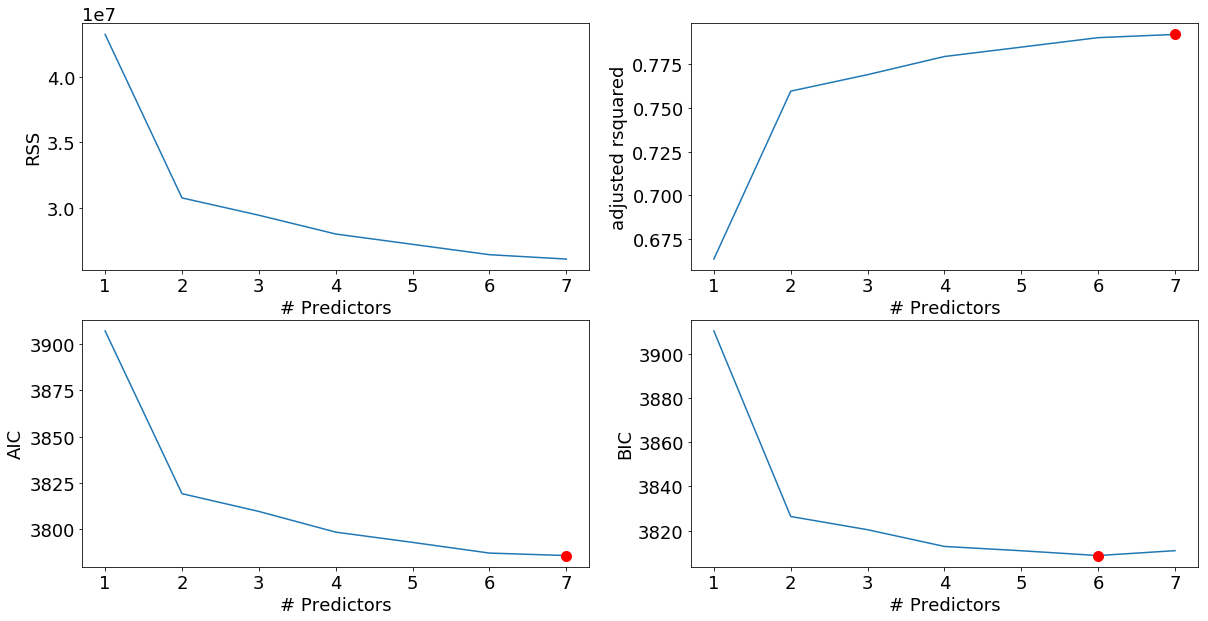

In [18]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_best["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

Recall that in the second step of our selection process, we narrowed the field down to just one model on any $k<=p$ predictors. We see that according to BIC, the best performer is the model with 6 variables. According to AIC and adjusted $R^2$ something a bit more complex might be better. Again, no one measure is going to give us an entirely accurate picture... but they all agree that a model with 5 or fewer predictors is insufficient.

# 6.5.2 Forward and Backward Stepwise Selection
We can also use a similar approach to perform forward stepwise
or backward stepwise selection, using a slight modification of the functions we defined above:

In [19]:
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

Now let's see how much faster it runs!

In [20]:
models_fwd = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

C:\Users\ActiveXchange\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Processed  19 models on 1 predictors in 0.038908958435058594 seconds.
Processed  18 models on 2 predictors in 0.03288531303405762 seconds.
Processed  17 models on 3 predictors in 0.027924537658691406 seconds.
Processed  16 models on 4 predictors in 0.03091740608215332 seconds.
Processed  15 models on 5 predictors in 0.025930404663085938 seconds.
Processed  14 models on 6 predictors in 0.024933815002441406 seconds.
Processed  13 models on 7 predictors in 0.023936033248901367 seconds.
Processed  12 models on 8 predictors in 0.03191375732421875 seconds.
Processed  11 models on 9 predictors in 0.023936033248901367 seconds.
Processed  10 models on 10 predictors in 0.023935794830322266 seconds.
Processed  9 models on 11 predictors in 0.021940946578979492 seconds.
Processed  8 models on 12 predictors in 0.018950223922729492 seconds.
Processed  7 models on 13 predictors in 0.014961004257202148 seconds.
Processed  6 models on 14 predictors in 0.012966156005859375 seconds.
Processed  5 models on

Phew! That's a lot better. Let's take a look:

In [21]:
print(models_fwd.loc[1, "model"].summary())
print(models_fwd.loc[2, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     519.2
Date:                Thu, 05 Sep 2019   Prob (F-statistic):           4.20e-64
Time:                        16:34:53   Log-Likelihood:                -1952.4
No. Observations:                 263   AIC:                             3907.
Df Residuals:                     262   BIC:                             3910.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Hits           4.8833      0.214     22.787      0.0

We see that using forward stepwise selection, the best one-variable
model contains only `Hits`, and the best two-variable model additionally
includes `CRBI`. Let's see how the models stack up against best subset selection:

In [22]:
print(models_best.loc[6, "model"].summary())
print(models_fwd.loc[6, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     166.3
Date:                Thu, 05 Sep 2019   Prob (F-statistic):           1.79e-85
Time:                        16:34:56   Log-Likelihood:                -1887.6
No. Observations:                 263   AIC:                             3787.
Df Residuals:                     257   BIC:                             3809.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AtBat         -1.5488      0.477     -3.248      0.0

For this data, the best one-variable through six-variable
models are each identical for best subset and forward selection.

# Backward Selection
Not much has to change to implement backward selection... just looping through the predictors in reverse!

In [23]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [24]:
models_bwd = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))

tic = time.time()
predictors = X.columns

while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

C:\Users\ActiveXchange\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  


Processed  19 models on 18 predictors in 0.04886889457702637 seconds.
Processed  18 models on 17 predictors in 0.035904645919799805 seconds.
Processed  17 models on 16 predictors in 0.0329129695892334 seconds.
Processed  16 models on 15 predictors in 0.030918359756469727 seconds.
Processed  15 models on 14 predictors in 0.02892279624938965 seconds.
Processed  14 models on 13 predictors in 0.026928424835205078 seconds.
Processed  13 models on 12 predictors in 0.02695465087890625 seconds.
Processed  12 models on 11 predictors in 0.03291153907775879 seconds.
Processed  11 models on 10 predictors in 0.025930404663085938 seconds.
Processed  10 models on 9 predictors in 0.01795172691345215 seconds.
Processed  9 models on 8 predictors in 0.01595759391784668 seconds.
Processed  8 models on 7 predictors in 0.013962268829345703 seconds.
Processed  7 models on 6 predictors in 0.013962507247924805 seconds.
Processed  6 models on 5 predictors in 0.011967658996582031 seconds.
Processed  5 models on 

For this data, the best one-variable through six-variable
models are each identical for best subset and forward selection.
However, the best seven-variable models identified by forward stepwise selection,
backward stepwise selection, and best subset selection are different:

In [25]:
print("------------")
print("Best Subset:")
print("------------")
print(models_best.loc[7, "model"].params)

------------
Best Subset:
------------
Hits            1.680029
Walks           3.399961
CAtBat         -0.328835
CHits           1.347017
CHmRun          1.349373
PutOuts         0.248166
Division_W   -111.943760
dtype: float64


In [26]:
print("-----------------")
print("Foward Selection:")
print("-----------------")
print(models_fwd.loc[7, "model"].params)

-----------------
Foward Selection:
-----------------
Hits            7.277149
CRBI            0.652415
Division_W   -110.656338
PutOuts         0.259787
AtBat          -1.644651
Walks           3.684324
League_N       49.978410
dtype: float64


In [27]:
print("-------------------")
print("Backward Selection:")
print("-------------------")
print(models_bwd.loc[7, "model"].params)

-------------------
Backward Selection:
-------------------
AtBat         -1.601655
Hits           6.148449
Walks          5.866033
CRuns          1.097453
CWalks        -0.650614
PutOuts        0.310125
Division_W   -95.027171
dtype: float64
